In [1]:
# from scipy.spatial import Delaunay
# import matplotlib.tri as mtri
# import numpy as np
# import xroms
# import xarray as xr


import xarray as xr
import xroms
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import cmocean.cm as cmo
import cf_xarray


In [2]:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
fname = '/Users/kthyng/packages/xroms/examples/txla2_his_a_latest.nc'
ds = xroms.open_netcdf(fname, chunks='auto', add_verts=True)

In [3]:
#set up plotting stuff
pc = cartopy.crs.PlateCarree()  # to match lon/lat
proj = cartopy.crs.LambertConformal(central_longitude=-90)  # projection for plot

# Run quick check plots

WILL NEED TO SEPARATE PLOT SETUP FROM PLOT TYPE FOR MAKING DIFFERENT COMBINATIONS

In [4]:
# change this to use logic in cf-xarray to identify variables
idvar = {}
idvar['temp'] = {'attrs': ['temp', 'Celsius'], 'cmap-sequential': cmo.thermal, 'cmap-diverging': cmo.balance}
idvar['salt'] = {'attrs': ['salt', 'salinity'], 'cmap-sequential': cmo.haline, 'cmap-diverging': cmo.diff}
idvar['vel'] = {'attrs': ['u-momentum', 'u-velocity', 'v-momentum', 'v-velocity', 'meter second-1', 'm/s', 'vel', 'velocity', 'speed'], 'cmap-diverging': cmo.delta, 'cmap-sequential': cmo.speed}
idvar['vort'] = {'attrs': ['vort', 'vorticity', 'second-1', '1/s'], 'cmap-diverging': cmo.curl, 'cmap-sequential': cmo.tempo}
idvar['zeta'] = {'attrs': ['zeta', 'ssh'], 'cmap-diverging': cmo.balance, 'cmap-sequential': cmo.amp}
idvar['rho'] = {'attrs': ['dense', 'density', 'kg/m^3'], 'cmap-diverging': cmo.diff, 'cmap-sequential': cmo.dense}
idvar['KE'] = {'attrs': ['energy', 'EKE', 'KE'], 'cmap-diverging': cmo.delta, 'cmap-sequential': cmo.speed}

def choosecmap(var):
    '''Choose type of variable and colormaps.
    
    Output:
    key      (str) Category of variable
    sequential colormap
    diverging colormap
    '''

    count = 0
    for key in idvar.keys():
        attrscomp = idvar[key]['attrs']
        for attrcomp in attrscomp:

            for attrin in var.attrs.values():
                try:  # can't do this process over grid object so skip that
                    if attrcomp in attrin:
                        count += 1
                except:
                    pass

            if (var.name is not None) and (attrcomp in var.name):
                count += 1
                
        if count>0:
            if (var.min()<0) & (var.max()>0):
                return idvar[key]['cmap-diverging']
            else:
                return idvar[key]['cmap-sequential']
    
    # if hasn't been caught
    return None


In [33]:
def setup_map(var, proj, ax=None, vartype=None, xy='ll', plottype='pcolormesh', land=True, coast=True, 
              rivers=False, states=False, vmin=None, vmax=None,
              top_labels=False, bottom_labels=True, right_labels=False, left_labels=True,
              transform=cartopy.crs.PlateCarree(), infer_intervals=True, robust=True, title=None):
    '''Plot var on lon/lat map with projection.
    
    Inputs:
    var          (DataArray) Variable to plot. Should already be subselected to be 2D in lon and lat.
    proj         (cartopy projection)
    
    options:
    xy           ('ll') Prefix for coords to use for x and y in plot. Default is 'll' for longitude and latitude.
                 In this case, coordinates associated with `var` which begin with "lon_" and "lat_" will be used 
                 for the x and y axises in the plot. Other options should be added.
    plottype     ('pcolormesh') `Matplotlib` plot function to use. Options: 'pcolormesh', 'contourf', or 'contour'.
    land         (True) Plot land.
    coast        (True) Plot coast.
    rivers       (False) Plot rivers.
    states       (False) Plot political borders.
    '''
    
    assert isinstance(proj,cartopy.crs.Projection), 'input "proj" must be a `cartopy` projection.'
    
    # store arguments for use after this function is called
    pargs = {}  # arguments to go into subsequent plot call
    oargs = {}  # other arguments that might be useful
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj))
#     else:
#         ax = plt.subplot(3, 3, 1, projection=proj)


    # Add natural features
    if land:
        ax.add_feature(cartopy.feature.LAND.with_scale('110m'), facecolor='0.8')
    if coast:
        ax.add_feature(cartopy.feature.COASTLINE.with_scale('10m'), edgecolor='0.2')
    if rivers:
        ax.add_feature(cartopy.feature.RIVERS.with_scale('110m'), edgecolor='b')
    if states:
        ax.add_feature(cartopy.feature.STATES.with_scale('110m'), edgecolor='k')
        
    if title is not None:
        ax.set_title(title)
        
    pargs['ax'] = ax

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)#, xlocs=np.arange(-104,-80,2))

    # manipulate `gridliner` object to change locations of labels
    gl.top_labels = top_labels
    gl.right_labels = right_labels
    gl.bottom_labels = bottom_labels
    gl.left_labels = left_labels
    oargs['gl'] = gl
    
#     if xy == 'll':
#         x = list(var.coords)[[coord[:4] == "lon_" for coord in var.coords].index(True)]
#         y = list(var.coords)[[coord[:4] == "lat_" for coord in var.coords].index(True)]
#     pargs['x'] = x
#     pargs['y'] = y
#     pargs['x'] = var[x]
#     pargs['y'] = var[y]
        
    # choose colormap
    if vartype is None:
        cmap = choosecmap(var)
    else:
        if (var.min()<0) & (var.max()>0):
            cmap = idvar[vartype]['cmap-diverging']
        else:
            cmap = idvar[vartype]['cmap-sequential']
    pargs['cmap'] = cmap

    # make sure min and max are balanced if diverging
    if vmin is None:
        vmin = var.min().values; 
    if vmax is None:
        vmax = var.max().values
    if (vmin < 0) & (vmax > 0):
        vmax = abs(var).max().values
        vmin = -vmax
#     print(vmin,vmax)
#     mappable = ax.pcolormesh(var[xkey], var[ykey], var, transform=pc, cmap=cmap, vmin=vmin, vmax=vmax)
#     plt.colorbar(mappable)
#     var.plot.contourf(ax=ax, x=xkey, y=ykey, transform=pc, cmap=cmap, vmin=vmin, vmax=vmax)
    pargs['vmin'] = vmin
    pargs['vmax'] = vmax
    
    pargs['transform'] = transform  # map projection that plot data is in. Assumed lon/lat or PlateCarree.
    pargs['infer_intervals'] = infer_intervals # for pcolormesh, infer the locations of cell edges from input locations of cell centers
    pargs['robust'] = robust  # for pcolormesh, use 2% to 98% values to choose range for colorbar
    pargs['add_labels'] = False  # don't override axis and colorbar labeling in call to plot
    

    return pargs, oargs

In [6]:
def plot_hov():
    '''Hovmoller plot (lon/lat vs time).'''

## Mapview annual mean of temperature

Try gridspec with constrained layout

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for 

Text(0.5, 1.0, 'Eddy kinetic energy (other model)')

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


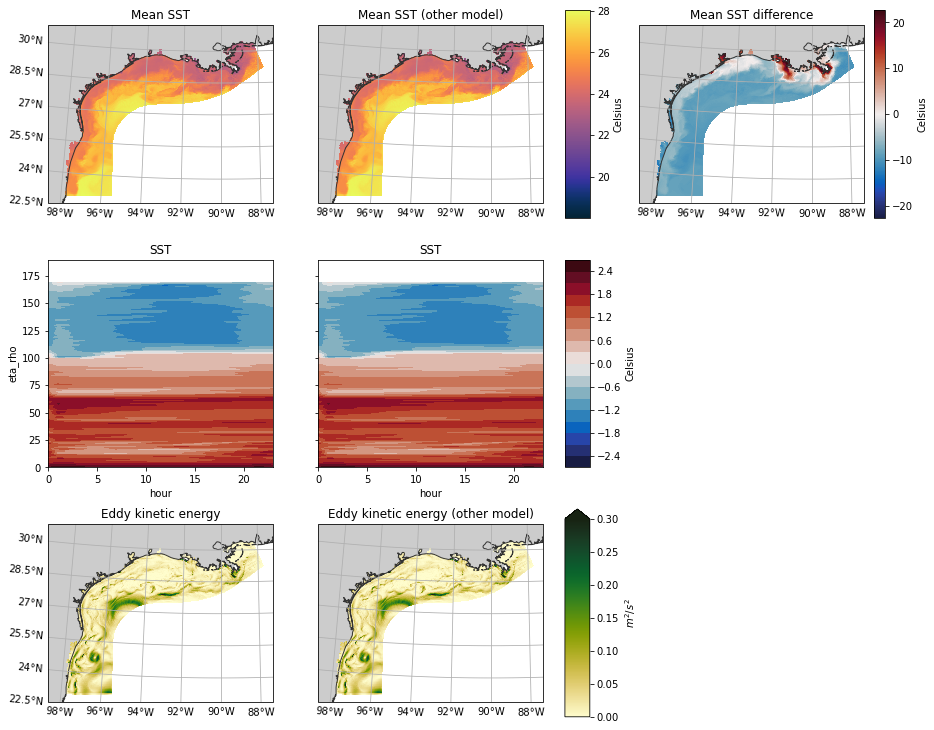

In [17]:
plt.rcParams['figure.constrained_layout.use'] = True
import matplotlib.gridspec as gridspec
# fig, axes = plt.subplots(1, 2) # HAVE TO USE ADD_SUBPLOT INSTEAD TO HAVE PROJECTION CHOICES DIFFERENT IN DIFF SUBPLOTS
fig = plt.figure(figsize=(15,13))
gs = fig.add_gridspec(3, 3)

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = fig.add_subplot(gs[0], projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax1)#, fig=fig, nrows=3, ncols=3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)
pargs['ax'].set_title('Mean SST')

ax2 = fig.add_subplot(gs[1], projection=proj)
# ax2 = plt.subplot(3, 3, 2, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius', 'ax': [ax1,ax2]})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Mean SST (other model)')

ax3 = fig.add_subplot(gs[2], projection=proj)
# ax3 = plt.subplot(3, 3, 3, projection=proj)
pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False)  # making up new variable to show difference
(var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius'})
pargs['ax'].set_title('Mean SST difference')


## Hovmoller ##
# var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = fig.add_subplot(gs[3])
# ax4 = plt.subplot(3, 3, 4)
cmap = choosecmap(var)  # choose colormap
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = fig.add_subplot(gs[4])
# ax5 = plt.subplot(3, 3, 5)
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax4,ax5], 'label': 'Celsius'})
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
ax7 = fig.add_subplot(gs[6], projection=proj)
# ax7 = plt.subplot(3, 3, 7, projection=proj)
var = ds.xroms.EKE.cf.mean('T', skipna=False)
pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy')

ax8 = fig.add_subplot(gs[7], projection=proj)
# ax8 = plt.subplot(3, 3, 8, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy (other model)')

# fig.tight_layout()
# fig.subplots_adjust(hspace=0.3)

In [ ]:
use not constrained_layout, but gridspec may be handy for controlling plots inside setup function

Put more stuff into setup_plot

In [27]:
var._labels

AttributeError: 'DataArray' object has no attribute '_labels'

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


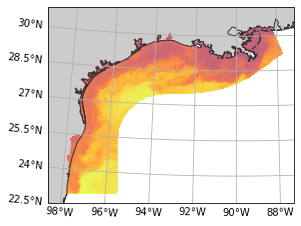

In [29]:
fig = plt.figure(figsize=(15,13))
gs = fig.add_gridspec(3, 3)

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = fig.add_subplot(gs[0], projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax1)#, fig=fig, nrows=3, ncols=3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False, add_labels=False)


/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for 

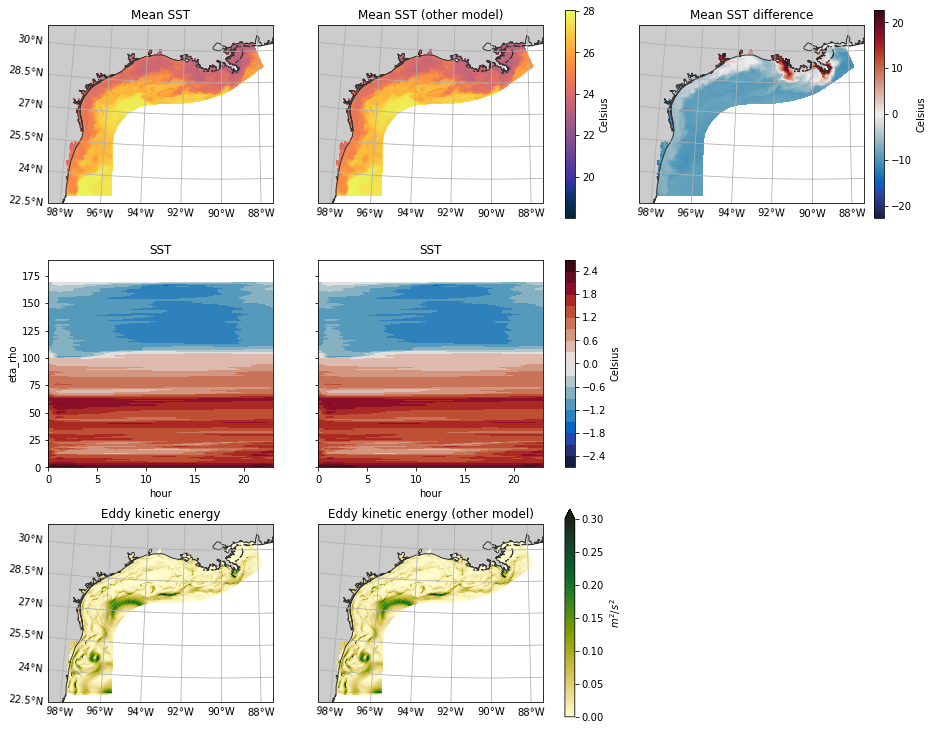

In [38]:
fig = plt.figure(figsize=(15,13))
nrows, ncols = 3, 3

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = plt.subplot(nrows, ncols, 1, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax1, title='Mean SST')
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)

ax2 = plt.subplot(nrows, ncols, 2, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False, title='Mean SST (other model)')
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius', 'ax': [ax1,ax2]})

ax3 = plt.subplot(nrows, ncols, 3, projection=proj)
pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False, title='Mean SST difference')  # making up new variable to show difference
(var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius'})


## Hovmoller ##
# var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = plt.subplot(nrows, ncols, 4)
cmap = choosecmap(var)  # choose colormap
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = plt.subplot(nrows, ncols, 5)
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'ax': [ax4,ax5], 'label': 'Celsius'})
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
var = ds.xroms.EKE.cf.mean('T', skipna=False)
ax7 = plt.subplot(nrows, ncols, 7, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3, title='Eddy kinetic energy')
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})

ax8 = plt.subplot(nrows, ncols, 8, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False, title='Eddy kinetic energy (other model)')
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})

# # fig.tight_layout()
# # fig.subplots_adjust(hspace=0.3)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for 

Text(0.5, 1.0, 'Eddy kinetic energy (other model)')

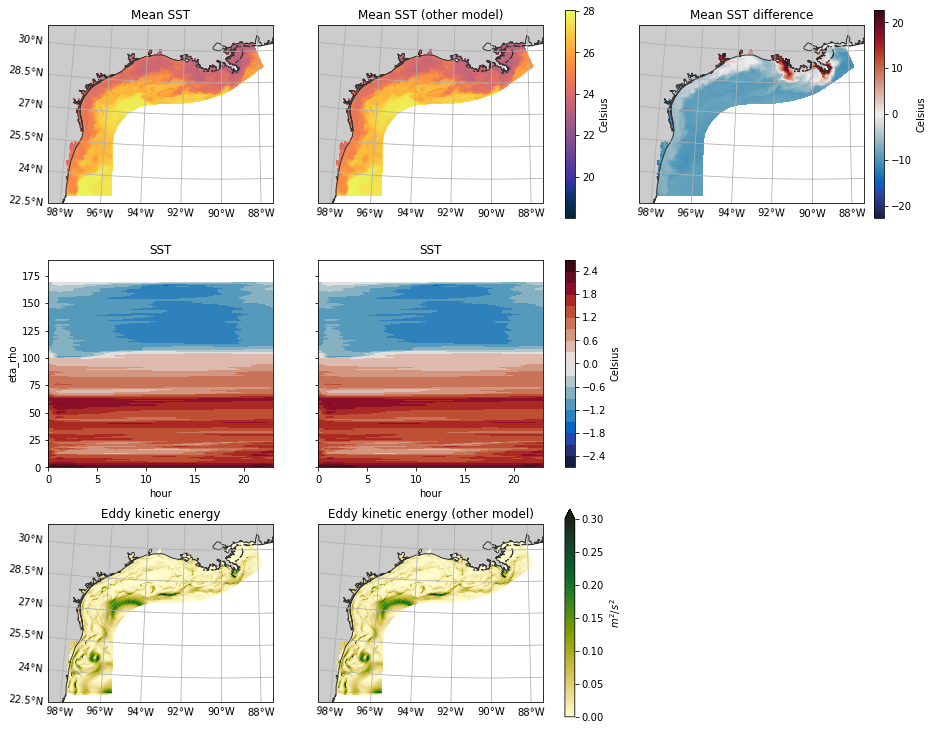

In [16]:
plt.rcParams['figure.constrained_layout.use'] = False
import matplotlib.gridspec as gridspec
# fig, axes = plt.subplots(1, 2) # HAVE TO USE ADD_SUBPLOT INSTEAD TO HAVE PROJECTION CHOICES DIFFERENT IN DIFF SUBPLOTS
fig = plt.figure(figsize=(15,13))
gs = fig.add_gridspec(3, 3)

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = fig.add_subplot(gs[0], projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax1)#, fig=fig, nrows=3, ncols=3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)
pargs['ax'].set_title('Mean SST')

ax2 = fig.add_subplot(gs[1], projection=proj)
# ax2 = plt.subplot(3, 3, 2, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius', 'ax': [ax1,ax2]})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Mean SST (other model)')

ax3 = fig.add_subplot(gs[2], projection=proj)
# ax3 = plt.subplot(3, 3, 3, projection=proj)
pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False)  # making up new variable to show difference
(var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius'})
pargs['ax'].set_title('Mean SST difference')


## Hovmoller ##
# var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = fig.add_subplot(gs[3])
# ax4 = plt.subplot(3, 3, 4)
cmap = choosecmap(var)  # choose colormap
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = fig.add_subplot(gs[4])
# ax5 = plt.subplot(3, 3, 5)
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax4,ax5], 'label': 'Celsius'})
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
ax7 = fig.add_subplot(gs[6], projection=proj)
# ax7 = plt.subplot(3, 3, 7, projection=proj)
var = ds.xroms.EKE.cf.mean('T', skipna=False)
pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy')

ax8 = fig.add_subplot(gs[7], projection=proj)
# ax8 = plt.subplot(3, 3, 8, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy (other model)')

# fig.tight_layout()
# fig.subplots_adjust(hspace=0.3)

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = False
import matplotlib.gridspec as gridspec
# fig, axes = plt.subplots(1, 2) # HAVE TO USE ADD_SUBPLOT INSTEAD TO HAVE PROJECTION CHOICES DIFFERENT IN DIFF SUBPLOTS
fig = plt.figure(figsize=(15,13))
gs = fig.add_gridspec(3, 3)

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = fig.add_subplot(gs[0], projection=proj)
pargs, oargs = setup_map(var, projection=proj, ax=ax1)#, fig=fig, nrows=3, ncols=3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)
pargs['ax'].set_title('Mean SST')

ax2 = fig.add_subplot(gs[1], projection=proj)
# ax2 = plt.subplot(3, 3, 2, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius', 'ax': [ax1,ax2]})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Mean SST (other model)')

ax3 = fig.add_subplot(gs[2], projection=proj)
# ax3 = plt.subplot(3, 3, 3, projection=proj)
pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False)  # making up new variable to show difference
(var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius'})
pargs['ax'].set_title('Mean SST difference')


## Hovmoller ##
# var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = fig.add_subplot(gs[3])
# ax4 = plt.subplot(3, 3, 4)
cmap = choosecmap(var)  # choose colormap
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = fig.add_subplot(gs[4])
# ax5 = plt.subplot(3, 3, 5)
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax4,ax5], 'label': 'Celsius'})
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
ax7 = fig.add_subplot(gs[6], projection=proj)
# ax7 = plt.subplot(3, 3, 7, projection=proj)
var = ds.xroms.EKE.cf.mean('T', skipna=False)
pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy')

ax8 = fig.add_subplot(gs[7], projection=proj)
# ax8 = plt.subplot(3, 3, 8, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy (other model)')

# fig.tight_layout()
# fig.subplots_adjust(hspace=0.3)

In [ ]:
NEED TO USE SPECIAL COLORBAR INPUTS

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for 

Text(0.5, 1.0, 'Eddy kinetic energy (other model)')

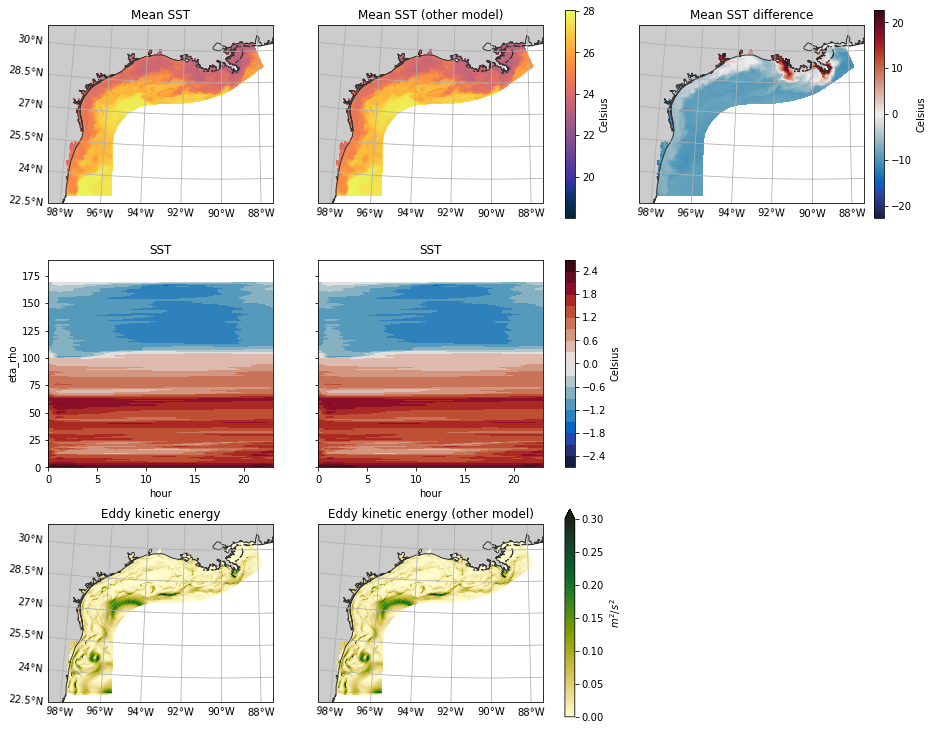

In [15]:
# fig, axes = plt.subplots(1, 2) # HAVE TO USE ADD_SUBPLOT INSTEAD TO HAVE PROJECTION CHOICES DIFFERENT IN DIFF SUBPLOTS
fig = plt.figure(figsize=(15,13))

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = plt.subplot(3, 3, 1, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax1)
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cbard = 0.02  # colorbar distance between plot and colorbar
cbarw = 0.01  # colorbar width
# cax = fig.add_axes([ax1.get_position().x1+cbard, ax1.get_position().y0, cbarw, ax1.get_position().height])
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)
pargs['ax'].set_title('Mean SST')

ax2 = plt.subplot(3, 3, 2, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Mean SST (other model)')

ax3 = plt.subplot(3, 3, 3, projection=proj)
pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False)  # making up new variable to show difference
(var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius'})
pargs['ax'].set_title('Mean SST difference')


## Hovmoller ##
# var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = plt.subplot(3, 3, 4)
cmap = choosecmap(var)  # choose colormap
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = plt.subplot(3, 3, 5)
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'ax': [ax4,ax5], 'label': 'Celsius'})
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
ax7 = plt.subplot(3, 3, 7, projection=proj)
var = ds.xroms.EKE.cf.mean('T', skipna=False)
pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy')

ax8 = plt.subplot(3, 3, 8, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy (other model)')

# fig.tight_layout()
# fig.subplots_adjust(hspace=0.3)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for 

Text(0.5, 1.0, 'Eddy kinetic energy (other model)')

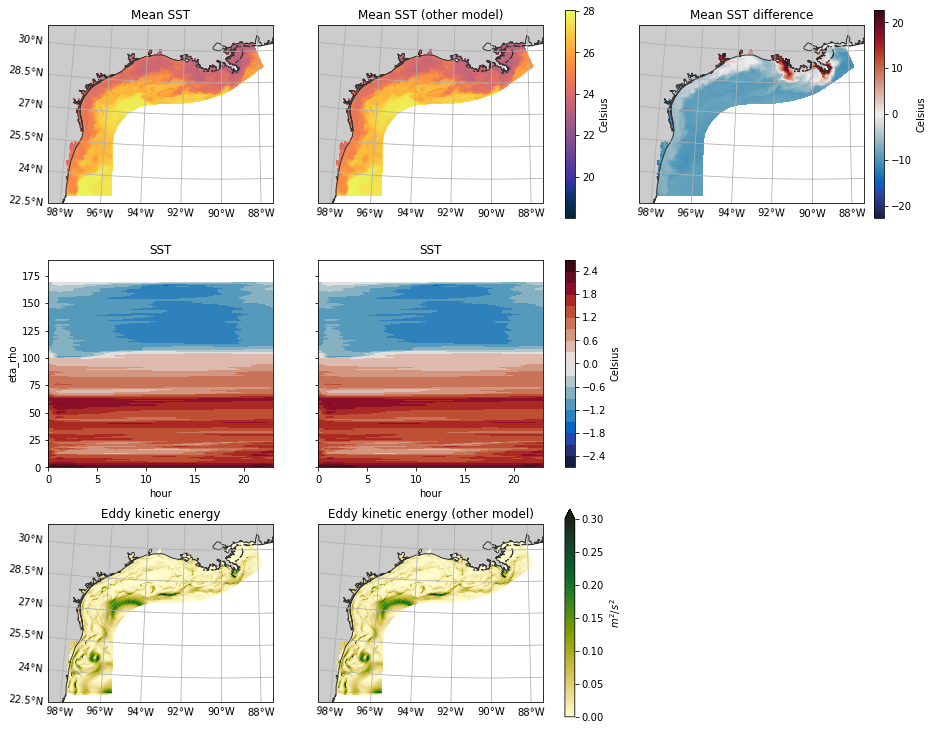

In [14]:
# fig, axes = plt.subplots(1, 2) # HAVE TO USE ADD_SUBPLOT INSTEAD TO HAVE PROJECTION CHOICES DIFFERENT IN DIFF SUBPLOTS
fig = plt.figure(figsize=(15,13))

## Mean SSTs ##
var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = plt.subplot(3, 3, 1, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax1)
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cbard = 0.02  # colorbar distance between plot and colorbar
cbarw = 0.01  # colorbar width
# cax = fig.add_axes([ax1.get_position().x1+cbard, ax1.get_position().y0, cbarw, ax1.get_position().height])
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)
pargs['ax'].set_title('Mean SST')

ax2 = plt.subplot(3, 3, 2, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Mean SST (other model)')

ax3 = plt.subplot(3, 3, 3, projection=proj)
pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False)  # making up new variable to show difference
(var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius'})
pargs['ax'].set_title('Mean SST difference')


## Hovmoller ##
# var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = plt.subplot(3, 3, 4)
cmap = choosecmap(var)  # choose colormap
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = plt.subplot(3, 3, 5)
var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax4,ax5], 'label': 'Celsius'})
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
ax7 = plt.subplot(3, 3, 7, projection=proj)
var = ds.xroms.EKE.cf.mean('T', skipna=False)
pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy')

ax8 = plt.subplot(3, 3, 8, projection=proj)
pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False)
var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
pargs['ax'].set_title('Eddy kinetic energy (other model)')

# fig.tight_layout()
# fig.subplots_adjust(hspace=0.3)

In [10]:
ds.xroms.EKE.cf.mean('T')

<xarray.DataArray 'EKE' (eta_rho: 191, xi_rho: 671)>
dask.array<mean_agg-aggregate, shape=(191, 671), dtype=float64, chunksize=(189, 669), chunktype=numpy.ndarray>
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    name:       EKE
    long_name:  eddy kinetic energy
    units:      m^2/s^2

In [8]:
ds.temp.attrs['grid']=''

In [9]:
ds.temp

<xarray.DataArray 'temp' (ocean_time: 24, s_rho: 30, eta_rho: 191, xi_rho: 671)>
dask.array<open_dataset-3fa24b2088d7fd1371eff2e4cd4f851etemp, shape=(24, 30, 191, 671), dtype=float32, chunksize=(24, 30, 191, 243), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(24, 30, 191, 671), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 191, 671), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      Celsius
    time:       ocean_time
    grid:       
    location:   face
    field:      temperature, scalar, series

In [3]:
ds.temp.cf.describe()

Axes:
	X: ['lon_rho']
	Y: ['lat_rho']
	Z: ['s_rho']
	T: ['ocean_time']

Coordinates:
	longitude: ['lon_rho']
	latitude: ['lat_rho']
	vertical: ['s_rho']
	time: ['ocean_time']

Cell Measures:
	area: []
	volume: []

Standard Names:
	unsupported



In [3]:
# ds.temp.cf['longitude']
ds.temp.cf.mean("longitude")

NameError: name 'ds' is not defined

In [144]:
ds.cf.guess_coord_axis(verbose=True)

RecursionError: maximum recursion depth exceeded while calling a Python object

<xarray.DataArray 'temp' (ocean_time: 24, s_rho: 30, eta_rho: 191, xi_rho: 671)>
dask.array<open_dataset-3fa24b2088d7fd1371eff2e4cd4f851etemp, shape=(24, 30, 191, 671), dtype=float32, chunksize=(24, 30, 191, 243), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(24, 30, 191, 671), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 191, 671), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      Celsius
    time:       ocean_time
    location:   face
    field:      temperature, scalar, series

In [44]:
pos = grid.axes['X']._get_axis_coord(ds.temp)[0]
if pos == 'center':
    pcolorpos = 'inner'
elif pos == 'inner':
    pcolorpos = 'center'
xkey = grid.axes['X'].coords[pcolorpos]
xkey

'xi_u'

In [82]:
grid.interp(ds.temp, ['X','Y'])

<xarray.DataArray 'mul-7db6d8a77712eeb930f16c1c1ec33f0a' (ocean_time: 24, s_rho: 30, eta_v: 190, xi_u: 670)>
dask.array<mul, shape=(24, 30, 190, 670), dtype=float32, chunksize=(24, 30, 190, 242), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Dimensions without coordinates: eta_v, xi_u

In [38]:
grid.axes['X'].coords['inner']

'xi_u'

In [20]:
grid._get_coords

AttributeError: 'Grid' object has no attribute '_get_coords'

In [10]:
ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour')

<xarray.DataArray 'temp' (hour: 24, eta_rho: 191)>
dask.array<stack, shape=(24, 191), dtype=float32, chunksize=(1, 191), chunktype=numpy.ndarray>
Coordinates:
    s_rho    float64 -0.01667
    lon_rho  (eta_rho) float64 dask.array<chunksize=(191,), meta=np.ndarray>
    lat_rho  (eta_rho) float64 dask.array<chunksize=(191,), meta=np.ndarray>
    z_rho0   (eta_rho) float64 dask.array<chunksize=(191,), meta=np.ndarray>
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: eta_rho
Attributes:
    long_name:  potential temperature, time mean over hour
    units:      Celsius
    time:       ocean_time
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...
    location:   face
    field:      temperature, scalar, series
    name:       temp

In [10]:
ds.xroms.EKE
ds.xroms.EKE.mean('ocean_time')

<xarray.DataArray 'EKE' (eta_rho: 191, xi_rho: 671)>
dask.array<mean_agg-aggregate, shape=(191, 671), dtype=float64, chunksize=(189, 669), chunktype=numpy.ndarray>
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    name:       EKE
    long_name:  eddy kinetic energy
    units:      m^2/s^2

In [26]:
ds.cf.describe()

Axes:
	X: []
	Y: []
	Z: ['s_rho', 's_w']
	T: []

Coordinates:
	longitude: ['lon_u', 'lon_rho', 'lon_v', 'lon_psi']
	latitude: ['lat_v', 'lat_rho', 'lat_u', 'lat_psi']
	vertical: ['s_rho', 's_w']
	time: []

Cell Measures:
	area: unsupported
	volume: unsupported

Standard Names:
	['latitude', 'latitude', 'latitude', 'latitude', 'longitude',
'longitude', 'longitude', 'longitude', 'ocean_s_coordinate_g2',
'ocean_s_coordinate_g2', 'upward_sea_water_velocity']


In [22]:
ds.temp.cf.describe()

Axes:
	X: []
	Y: []
	Z: ['s_rho']
	T: []

Coordinates:
	longitude: ['lon_rho']
	latitude: ['lat_rho']
	vertical: ['s_rho']
	time: []

Cell Measures:
	area: []
	volume: []

Standard Names:
	unsupported



In [27]:
ds.coords

Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w         (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 dask.array<chunksize=(191, 670), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float64 dask.array<chunksize=(190, 671), meta=np.ndarray>
    lon_psi     (eta_v, xi_u) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
    lat_psi     (eta_v, xi_u) float64 dask.array<chunksize=(190, 670), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
    z_w         (ocean_time, s_w, eta_

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

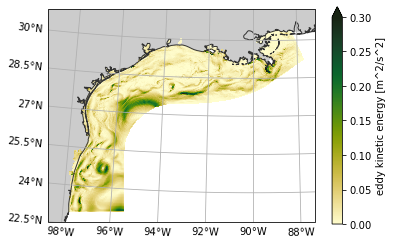

In [15]:
var = ds.xroms.EKE.mean('ocean_time')
# ds['EKE'] = var
plot_map(var, proj, vmin=0, vmax=0.3)